<div class="row">
    <div class="column">
        <img src="logos/metpy_400x400.png" width=125 alt="MetPy Logo"></img>
    </div>
    <div class="column">
        <img src="logos/unidata_logo_horizontal.png" width=250 alt="Unidata Logo"></img>
    </div>
</div>

# MetPy for analysis and visualization of diverse data

---

## Overview


1. 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: 
- **System requirements**:
    - 

---

## Imports

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from metpy.plots import StationPlot

## Crash Course to MetPy

### Units and calculations

In [2]:
from metpy.units import units

In [3]:
miles = 3.5 * units.mi
hour = units.Quantity(0.5, "hour")

print(miles, hour)

3.5 mile 0.5 hour


In [4]:
speed = miles / hour
speed

7.0 <Unit('mile / hour')>

In [5]:
speed.to("m/s")

3.1292800000000005 <Unit('meter / second')>

In [6]:
temp_outside = 25 * units.degC
temp_increase = 2.5 * units.degC

temp_outside + temp_increase

OffsetUnitCalculusError: Ambiguous operation with offset unit (degree_Celsius, degree_Celsius). See https://pint.readthedocs.io/en/stable/user/nonmult.html for guidance.

In [7]:
temp_outside - temp_increase

22.5 <Unit('delta_degree_Celsius')>

In [8]:
temp_outside + (2.5 * units.delta_degC)

27.5 <Unit('degree_Celsius')>

In [9]:
import metpy.calc as mpcalc
u = 30 * units.knots
v = 5 * units("m/s")

mpcalc.wind_direction(u, v)

array(252.04901961) <Unit('degree')>

### MetPy for plots you love

In [10]:
from metpy.plots import SkewT

In [11]:
df = pd.read_fwf("../../data/sounding_data/bmx_sounding_20080411_12Z.txt")
df

,-----------------------------------------------------------------------------
0,PRES HGHT TEMP DWPT RELH MIXR DRCT...
1,hPa m C C % g/kg deg ...
2,----------------------------------------------...
3,1000.0 110
4,993.0 178 19.0 17.0 88 12.42 16...
...,...
136,10.5 30480 -47.4 -82.4 1 0.04 310...
137,10.0 30780 -47.5 -82.5 1 0.04 280...
138,8.7 31716 -39.5 -76.5 1 0.13 ...
139,8.7 31699 -39.6 -76.6 1 0.13 275 ...


In [12]:
names_header = "   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV"

# slight tweak
units_header = "    hPa     m      degC      degC      %    g/kg    deg   knot     K      K      K "

df = pd.read_fwf("../../data/sounding_data/bmx_sounding_20080411_12Z.txt",
                header=None, skiprows=4, names=names_header.split())
df

,PRES,HGHT,TEMP,DWPT,RELH,MIXR,DRCT,SKNT,THTA,THTE,THTV
0,1000.0,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,993.0,178,19.0,17.0,88.0,12.42,160.0,9.0,292.7,328.2,294.9
2,988.0,221,18.8,16.6,87.0,12.17,164.0,11.0,293.0,327.8,295.1
3,959.0,474,17.0,16.6,97.0,12.54,187.0,23.0,293.6,329.6,295.9
4,943.7,610,17.1,16.8,98.0,12.94,200.0,29.0,295.1,332.4,297.4
...,...,...,...,...,...,...,...,...,...,...,...
133,10.5,30480,-47.4,-82.4,1.0,0.04,310.0,12.0,830.5,831.1,830.6
134,10.0,30780,-47.5,-82.5,1.0,0.04,280.0,7.0,841.1,841.7,841.1
135,8.7,31716,-39.5,-76.5,1.0,0.13,NaN,NaN,906.3,908.1,906.4
136,8.7,31699,-39.6,-76.6,1.0,0.13,275.0,14.0,905.1,906.8,905.1


In [13]:
df = df.dropna(subset=('TEMP', 'DWPT', 'DRCT', 'SKNT'), how="all").reset_index(drop=True)
df

,PRES,HGHT,TEMP,DWPT,RELH,MIXR,DRCT,SKNT,THTA,THTE,THTV
0,993.0,178,19.0,17.0,88.0,12.42,160.0,9.0,292.7,328.2,294.9
1,988.0,221,18.8,16.6,87.0,12.17,164.0,11.0,293.0,327.8,295.1
2,959.0,474,17.0,16.6,97.0,12.54,187.0,23.0,293.6,329.6,295.9
3,943.7,610,17.1,16.8,98.0,12.94,200.0,29.0,295.1,332.4,297.4
4,926.0,770,17.2,17.1,99.0,13.43,205.0,35.0,296.8,335.8,299.2
...,...,...,...,...,...,...,...,...,...,...,...
132,10.5,30480,-47.4,-82.4,1.0,0.04,310.0,12.0,830.5,831.1,830.6
133,10.0,30780,-47.5,-82.5,1.0,0.04,280.0,7.0,841.1,841.7,841.1
134,8.7,31716,-39.5,-76.5,1.0,0.13,NaN,NaN,906.3,908.1,906.4
135,8.7,31699,-39.6,-76.6,1.0,0.13,275.0,14.0,905.1,906.8,905.1


In [14]:
from metpy.units import pandas_dataframe_to_unit_arrays

units_dict = {col: unit for col, unit in zip(names_header.split(), units_header.split())}
units_dict

{'PRES': 'hPa',
 'HGHT': 'm',
 'TEMP': 'degC',
 'DWPT': 'degC',
 'RELH': '%',
 'MIXR': 'g/kg',
 'DRCT': 'deg',
 'SKNT': 'knot',
 'THTA': 'K',
 'THTE': 'K',
 'THTV': 'K'}

In [15]:
data = pandas_dataframe_to_unit_arrays(df, units_dict)
data["PRES"]

Magnitude,[993.0 988.0 959.0 943.7 926.0 925.0 916.0 910.5 906.0 878.4 850.0 845.0 817.2 788.0 787.0 781.0 778.0 773.0 765.0 762.0 759.7 744.0 742.0 737.0 734.0 732.2 719.0 705.6 705.0 700.0 680.0 679.0 677.0 675.0 674.0 672.0 657.0 654.8 654.0 652.0 645.0 640.0 628.0 626.0 619.0 616.0 607.0 594.0 579.0 570.0 562.0 500.0 499.9 480.2 443.1 430.0 414.0 408.0 400.0 391.8 360.0 350.0 316.2 304.0 300.0 278.0 256.0 250.0 226.0 215.0 211.0 210.0 209.4 202.0 200.0 187.0 181.1 181.0 167.0 164.2 163.0 152.0 150.0 148.8 141.6 140.0 136.0 129.0 128.1 124.0 121.8 121.0 115.0 113.0 110.0 108.0 100.0 85.2 83.6 82.1 81.0 80.6 77.0 73.1 70.0 68.4 66.0 65.2 64.5 59.7 56.1 52.6 50.0 48.2 44.3 44.0 42.6 39.1 37.7 36.2 34.5 32.0 30.2 30.0 26.9 26.3 20.0 17.2 16.7 16.0 13.2 11.4 10.5 10.0 8.7 8.7 8.4]
Units,hectopascal


In [16]:
df["PRES"].values * units.hPa

Magnitude,[993.0 988.0 959.0 943.7 926.0 925.0 916.0 910.5 906.0 878.4 850.0 845.0 817.2 788.0 787.0 781.0 778.0 773.0 765.0 762.0 759.7 744.0 742.0 737.0 734.0 732.2 719.0 705.6 705.0 700.0 680.0 679.0 677.0 675.0 674.0 672.0 657.0 654.8 654.0 652.0 645.0 640.0 628.0 626.0 619.0 616.0 607.0 594.0 579.0 570.0 562.0 500.0 499.9 480.2 443.1 430.0 414.0 408.0 400.0 391.8 360.0 350.0 316.2 304.0 300.0 278.0 256.0 250.0 226.0 215.0 211.0 210.0 209.4 202.0 200.0 187.0 181.1 181.0 167.0 164.2 163.0 152.0 150.0 148.8 141.6 140.0 136.0 129.0 128.1 124.0 121.8 121.0 115.0 113.0 110.0 108.0 100.0 85.2 83.6 82.1 81.0 80.6 77.0 73.1 70.0 68.4 66.0 65.2 64.5 59.7 56.1 52.6 50.0 48.2 44.3 44.0 42.6 39.1 37.7 36.2 34.5 32.0 30.2 30.0 26.9 26.3 20.0 17.2 16.7 16.0 13.2 11.4 10.5 10.0 8.7 8.7 8.4]
Units,hectopascal


In [17]:
p = data["PRES"]
t = data["TEMP"]
td = data["DWPT"]

In [18]:
u, v = mpcalc.wind_components(data["SKNT"], data["DRCT"])

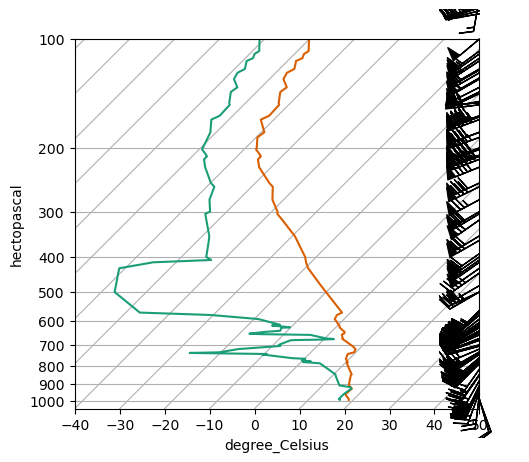

In [19]:
fig = plt.figure()

skew = SkewT(fig, rotation=45)

skew.plot(p, t, color="#d95f02")
skew.plot(p, td, color="#1b9e77")

skew.plot_barbs(p, u , v)

/var/folders/3f/3w3flt9x5rd9y8zbsc7cvvzw0000gp/T/ipykernel_41171/583312609.py:14: UserWarning: Duplicate pressure(s) [8.7] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')


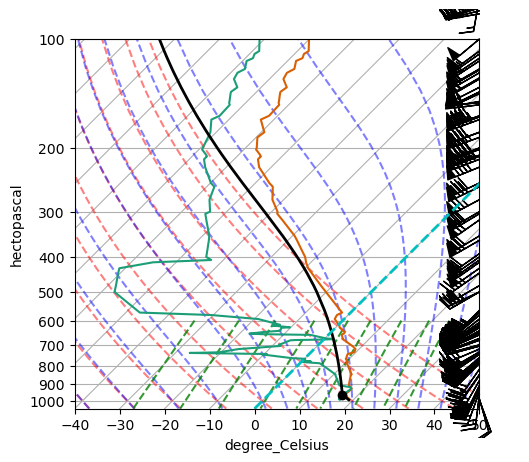

In [20]:
fig = plt.figure()

skew = SkewT(fig, rotation=45)

skew.plot(p, t, color="#d95f02")
skew.plot(p, td, color="#1b9e77")

skew.plot_barbs(p, u , v)

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

### MetPy for annoying data you love

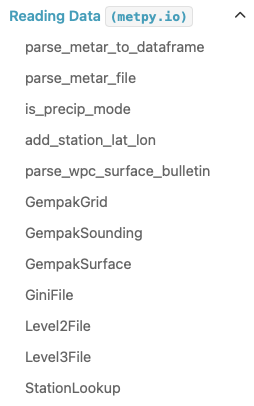

In [21]:
from metpy.io import parse_metar_file

In [22]:
df = pd.read_csv("../../data/metpy/asos.csv")
df

,KMDQ 110000Z AUTO 16013G19KT 10SM SCT047 OVC050 25/15 A2985 RMK AO2 LTG DSNT NW
0,KMDQ 110020Z AUTO 17009G17KT 10SM SCT048 BKN06...
1,KMDQ 110040Z AUTO 16010G16KT 10SM BKN044 BKN05...
2,METAR KHSV 110053Z 17014KT 10SM BKN040 BKN055 ...
3,KDCU 110053Z AUTO 17013G20KT 10SM FEW060 23/17...
4,KMDQ 110100Z AUTO 17010G17KT 10SM SCT044 SCT04...
...,...
150,KMDQ 112300Z AUTO 20008KT 10SM BKN070 BKN090 2...
151,KMDQ 112320Z AUTO 19007KT 10SM BKN060 OVC095 2...
152,KMDQ 112340Z AUTO 18006KT 10SM BKN070 OVC095 2...
153,METAR KHSV 112353Z 19004KT 10SM OVC070 21/16 A...


In [24]:
metars = parse_metar_file("../../data/metpy/asos.csv", month=4, year=2008).set_index("date_time")
metars

,station_id,latitude,longitude,elevation,wind_direction,wind_speed,wind_gust,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,
2008-04-11 00:00:00,KMDQ,34.86,-86.55,230,160,13.0,19.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2 LTG DSNT NW,1010.12,-4.446262e+00,12.216004
2008-04-11 00:20:00,KMDQ,34.86,-86.55,230,170,9.0,17.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2,1010.12,-1.562834e+00,8.863270
2008-04-11 00:40:00,KMDQ,34.86,-86.55,230,160,10.0,16.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2,1010.12,-3.420201e+00,9.396926
2008-04-11 00:53:00,KHSV,34.65,-86.78,191,170,14.0,NaN,16093.44,NaN,NaN,...,24.0,17.0,29.86,0,0,0,AO2 SLP106 T02440167,1010.72,-2.431074e+00,13.787309
2008-04-11 00:53:00,KDCU,34.65,-86.95,176,170,13.0,20.0,16093.44,NaN,NaN,...,23.0,17.0,29.84,0,0,0,AO2 SLP100 T02330172,1010.17,-2.257426e+00,12.802501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-11 22:53:00,KHSV,34.65,-86.78,191,230,9.0,NaN,16093.44,NaN,NaN,...,21.0,12.0,29.79,0,0,0,AO2 SLP082 T02110122,1008.57,6.894400e+00,5.785088
2008-04-11 23:00:00,KMDQ,34.86,-86.55,230,200,8.0,NaN,16093.44,NaN,NaN,...,21.0,16.0,29.78,0,0,0,AO2,1008.10,2.736161e+00,7.517541
2008-04-11 23:20:00,KMDQ,34.86,-86.55,230,190,7.0,NaN,16093.44,NaN,NaN,...,20.0,13.0,29.77,0,0,0,AO2 LTG DSNT E AND S,1007.85,1.215537e+00,6.893654


In [25]:
subset = metars.loc["2008-04-11 18:00:00": "2008-04-11 19:00:00"]

In [26]:
subset

,station_id,latitude,longitude,elevation,wind_direction,wind_speed,wind_gust,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,
2008-04-11 18:00:00,KMDQ,34.86,-86.55,230,190,18.0,25.0,16093.440,NaN,NaN,...,26.0,17.0,29.76,0,0,0,AO2 LTG DSNT N,1006.97,3.125667,17.726540
2008-04-11 18:10:00,KDCU,34.65,-86.95,176,200,12.0,25.0,4023.360,+RA,NaN,...,23.0,19.0,29.74,65,0,0,AO2 LTG DSNT NW RAB01 P0007,1006.77,4.104242,11.276311
2008-04-11 18:20:00,KMDQ,34.86,-86.55,230,190,18.0,25.0,16093.440,NaN,NaN,...,26.0,17.0,29.74,0,0,0,AO2 LTG DSNT W THRU NE,1006.29,3.125667,17.726540
2008-04-11 18:22:00,KDCU,34.65,-86.95,176,210,19.0,30.0,11265.408,-RA,NaN,...,24.0,19.0,29.75,61,0,0,AO2 PK WND 20030/1820 LTG DSNT W-N RAB01 P0009,1007.04,9.500000,16.454483
2008-04-11 18:30:00,KDCU,34.65,-86.95,176,220,10.0,28.0,11265.408,-TSRA,NaN,...,23.0,19.0,29.75,1095,0,0,AO2 PK WND 20030/1820 LTG DSNT ALQDS TSB24RAB0...,1007.11,6.427876,7.660444
2008-04-11 18:40:00,KMDQ,34.86,-86.55,230,190,21.0,26.0,11265.408,-VCTSRA,NaN,...,24.0,18.0,29.74,1095,0,0,AO2 LTG DSNT ALQS,1006.47,3.646612,20.680963
2008-04-11 18:53:00,KDCU,34.65,-86.95,176,250,8.0,NaN,14484.096,VCTS,-RA,...,22.0,19.0,29.76,13,61,0,AO2 PK WND 20030/1820 LTG DSNT ALQDS TSB24E51B...,1007.52,7.517541,2.736161
2008-04-11 18:53:00,KHSV,34.65,-86.78,191,210,16.0,28.0,16093.440,NaN,NaN,...,26.0,17.0,29.77,0,0,0,AO2 PK WND 19030/1804 SLP075 CB NW MOV NE T026...,1007.51,8.000000,13.856406
2008-04-11 18:55:00,KHUA,34.68,-86.68,209,200,14.0,20.0,11265.408,NaN,NaN,...,26.0,18.0,29.77,0,0,0,,1007.42,4.788282,13.155697


### xarray, CF conventions, and MetPy

In [27]:
armor_file = "../pydda/output_grid_ARMOR.nc"
khtx_file = "../pydda/output_grid_KHTX.nc"

In [28]:
ds = xr.open_dataset(khtx_file)

In [29]:
ds['u'].attrs['units'] = "meters per second"
ds['v'].attrs['units'] = "meters per second"

In [30]:
direction = mpcalc.wind_direction(ds.u, ds.v)
direction

Magnitude,[[[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] ... [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]]]
Units,degree


(array([   933.,   2549.,   1002.,    357.,    238.,  12617., 194423.,
          6874.,   1781.,    610.]),
 array([1.51441755e-01, 3.61284696e+01, 7.21054974e+01, 1.08082525e+02,
        1.44059553e+02, 1.80036581e+02, 2.16013609e+02, 2.51990636e+02,
        2.87967664e+02, 3.23944692e+02, 3.59921720e+02]),
 <BarContainer object of 10 artists>)

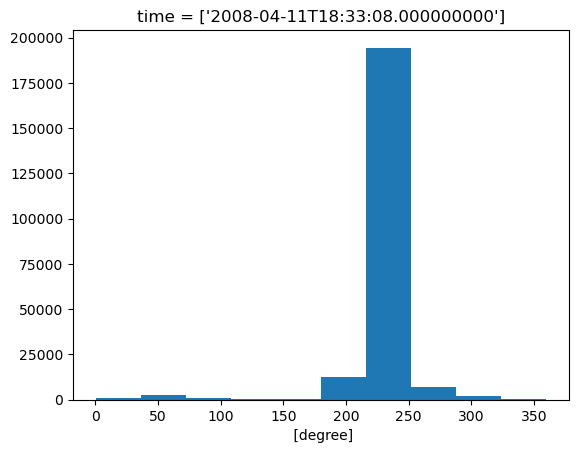

In [31]:
direction.plot.hist()

---

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

---

## Summary

### What's next?


## Resources and references
 - 